# Module 6: CFA
# Use Case: Credit Risk - Identifying Bad Credit Risks
# ===========================================

In this example, we aim to predict bad consumer credits, and we develop a classification model for this purpose, driven by loan and debtor attributes. We would use this model to accept or reject a customer’s business.

Dataset: Credit risk https://datahub.io/machine-learning/credit-g
Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

In [427]:
# package for working with tabular data
import pandas as pd 
import numpy as np

# Package for charting
import matplotlib.pyplot as plt
import seaborn as sns #charts

# package for timing runtime
import time

# package for navigating the operating system
import os

If this is running in Google Colab.... we extract the GitHub loc where the data resides....

In [428]:
!git clone https://github.com/danphilps/credit_use_case

Cloning into 'credit_use_case'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 48 (delta 17), reused 19 (delta 3), pack-reused 0
Unpacking objects: 100% (48/48), done.


In [429]:
# We should see a "credit_use_case" directory....
os.listdir()

['README.md',
 'M6_CreditScoring.ipynb',
 'Ch20_AutoML.ipynb',
 '.gitattributes',
 'ch19_Classification_ Models_and_ Evaluation_use_case.ipynb',
 'credit_use_case',
 '.git',
 'credit-g.csv']

In [430]:
os.chdir('credit_use_case')

In [431]:
loc = "credit-g.csv"
start_time = time.time()
df_raw = pd.read_csv(loc)
print("It took %s seconds to load the .xlsx file." % (time.time() - start_time))

It took 0.016061782836914062 seconds to load the .xlsx file.


## Bias Alert: Protected and Priviledged Groups...

Loan approval is a high risk application. We need to go very carefully as a result. We need to identify any protected characteristics (ie it would be illegal to differentiate based on these) present in the dataset. 
Our use-case is a loan approval use case, ethnicity and gender are protected charcteristics where biases would be illegal. We clearly need to remove these features.
It is also possible to identify priviledged groups and remove biases based on these characterictics. 


In [432]:
df_raw.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker', 'class'],
      dtype='object')

In [433]:
# Protected data items - 'personal_status' has a "sex" classifier - REMOVE!
df = df_raw.drop(columns=['personal_status'])

# Priviledged dataitems - remove all ages < 25
df['age'] = df_raw['age'][lambda x: x >= 25]


In [434]:
# Check for biases on protected characteristics...
df_female = df_raw[(df_raw['personal_status'].str.contains('female') != 0)]
df_male = df_raw[(df_raw['personal_status'].str.contains('female') == 0)]

# % of females 
female_good_credits = df_female[(df_female['class'] == 'good')].shape[0]
female_good_credits_pct = female_good_credits / df_female.shape[0]
#
male_good_credits = df_male[(df_male['class'] == 'good')].shape[0] 
male_good_credits_pct = male_good_credits / df_male.shape[0]

#  Difference in good credits for females and males...
print('Female good credits: ' + str(format(round(female_good_credits_pct*100, 2))) + '%')
print('Male good credits: ' + str(format(round(male_good_credits_pct*100, 2))) + '%')


Female good credits: 64.84%
Male good credits: 72.32%


There is clearly a bias in the dataset, but to expand upon this we can use a Chi2 test to examine whether the observed "bad" credits we see in female rows, is statistically significant to the expected difference we see in male rows.

It is possible that this bias is proxied by another data item in the dataset. **We will come back to this issue later**.

In [435]:
from scipy.stats import chi2_contingency

# Generate  confusion matrix that to examine this bias...
df_raw['gender'] = np.where(df_raw['personal_status'].str.contains('female') == 0, 'female', 'male')
conf_matrix= pd.crosstab(df_raw['gender'], df_raw['class']) 

print('Male/Female Good/Bad Credits Confusion Matrix \n' + str(conf_matrix))

# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(conf_matrix) 
# Print the p-value
print('\n Chi-square test of independence')
print('p-val of Chi2 test: ' + str(round(p, 4)))

Male/Female Good/Bad Credits Confusion Matrix 
class   bad  good
gender           
female  191   499
male    109   201

 Chi-square test of independence
p-val of Chi2 test: 0.0207


# Data Wrangling and Preprocessing

Data Wrangling: As we have shown in previous chapters we need to convert categorical data into one-hot-encodings, clean characters from numeric data columns, carry out type conversions into numeric datatypes... The following cell shows the appropriate data wrangling to get our data into a good shape. 

In [436]:
# list categorical columns...
cat_cols =['checking_status', 'purpose', 'credit_history', 'savings_status', 'employment', 'other_parties', 'property_magnitude', 'other_payment_plans','housing','job','own_telephone']

# One hot encoding of catagorical variables...
df[cat_cols].astype("category")
one_hot_encodings = pd.get_dummies(df[cat_cols])

#Combine dfs
df = pd.concat([df, one_hot_encodings], axis=1)

#remove categorical columns...
df = df.drop(columns=cat_cols)

#Data wrangling..... get types and bad values sorted out

# Remove characters in numeric columns (note that the data type was set, by the open_csv function to object, 
# so we first convert to string before running the replace function (which can only be fun on str types)
df['foreign_worker'] = df['foreign_worker'].str.replace('yes', '1')
df['foreign_worker'] = df['foreign_worker'].str.replace('no', '0')
df['class'] = df['class'].str.replace('good', '0')
df['class'] = df['class'].str.replace('bad', '1')

# Convert to numerics so we can use in ML... we force type conversions, then print our resulting df.
df['foreign_worker'] = pd.to_numeric(df['foreign_worker'], errors ='coerce').fillna(0).astype('int')
df['class'] = pd.to_numeric(df['class'], errors ='coerce').fillna(0).astype('int')
df['duration'] = pd.to_numeric(df['duration'], errors ='coerce').fillna(0).astype('int')
df['installment_commitment'] = pd.to_numeric(df['installment_commitment'], errors ='coerce').fillna(0).astype('int')
df['residence_since'] = pd.to_numeric(df['residence_since'], errors ='coerce').fillna(0).astype('int')
df['age'] = pd.to_numeric(df['age'], errors ='coerce').fillna(0).astype('int')
df['num_dependents'] = pd.to_numeric(df['num_dependents'], errors ='coerce').fillna(0).astype('int')

df

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents,foreign_worker,class,checking_status_0<=X<200,...,other_payment_plans_stores,housing_for free,housing_own,housing_rent,job_high qualif/self emp/mgmt,job_skilled,job_unemp/unskilled non res,job_unskilled resident,own_telephone_none,own_telephone_yes
0,6,1169,4,4,67,2,1,1,0,0,...,0,0,1,0,0,1,0,0,0,1
1,48,5951,2,2,0,1,1,1,1,1,...,0,0,1,0,0,1,0,0,1,0
2,12,2096,2,3,49,1,2,1,0,0,...,0,0,1,0,0,0,0,1,1,0
3,42,7882,2,4,45,1,2,1,0,0,...,0,1,0,0,0,1,0,0,1,0
4,24,4870,3,4,53,2,2,1,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,12,1736,3,4,31,1,1,1,0,0,...,0,0,1,0,0,0,0,1,1,0
996,30,3857,4,4,40,1,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
997,12,804,4,4,38,1,1,1,0,0,...,0,0,1,0,0,1,0,0,1,0
998,45,1845,4,4,0,1,1,1,1,0,...,0,1,0,0,0,1,0,0,0,1


In [437]:
df.columns

Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'foreign_worker', 'class', 'checking_status_0<=X<200',
       'checking_status_<0', 'checking_status_>=200',
       'checking_status_no checking', 'purpose_business',
       'purpose_domestic appliance', 'purpose_education',
       'purpose_furniture/equipment', 'purpose_new car', 'purpose_other',
       'purpose_radio/tv', 'purpose_repairs', 'purpose_retraining',
       'purpose_used car', 'credit_history_all paid',
       'credit_history_critical/other existing credit',
       'credit_history_delayed previously', 'credit_history_existing paid',
       'credit_history_no credits/all paid', 'savings_status_100<=X<500',
       'savings_status_500<=X<1000', 'savings_status_<100',
       'savings_status_>=1000', 'savings_status_no known savings',
       'employment_1<=X<4', 'employment_4<=X<7', 'employment_<1',
       'employment_>=7', 'employment_une

## Bias Alert: Imbalanced dataset

Imbalances in datasets for classification problems are a big issue. We generally need to balance the dataset to contain an equal proportion of the different classes before training (and testing). For the credit use-case, we have two classes {1,0}, meaning that ideally 50% of our samples should be class=1; and 50% class=0. If this is not the case and we have an imbalance (we do), we can balance the data by up-sampling the minority class, or down-sampling the majority class.
Let us first examine the dataset to determine whether it is in balance.

Imbalanced dataset....
0    700
1    300
Name: class, dtype: int64


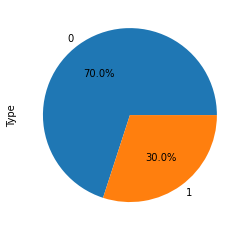

In [438]:

#Pie chart of imbalances wrapped as a func as we will use it a few times..
def pie_of_imbalance(df: pd.DataFrame, class_col: str = 'class'):
    print('Imbalanced dataset....')
    print(df[class_col].value_counts())
    df.groupby(class_col).size().plot(kind='pie', y = 'class', label = "Type",  autopct='%1.1f%%')
    
#run func
pie_of_imbalance(df)

The dataset is not balanced. 70% of samples are class=0; only 30% are class=1. We should bring this into balance before we train our model, or risk introducing dangerous biases into our forecasts.

### NB: Separate training and testing datasets BEFORE balancing the dataset

Before we start up or down-sampling to correct the imbalance, we first we need to create our testing and training datasets. We can then balance the training set. This is to keep the training-set in-sample and the testing-set strictly out-of-sample. This is crucial as our learner must not see any of the test samples until we actually test it for performance. If we fail to separate testing and training data before up samplng, we can suffer data-snooping biases (also called data-leakage), which would invalidate our model.

In [439]:
from sklearn.model_selection import train_test_split

In [440]:
# Define X and y variables
cols  = list(df.columns)
cols.remove('class')

# Contains only numerics
X = df[cols]
y = df['class']

#Test and train set    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

### RandomForest Classifier
We will use the RandomForest classifier to help us test different up and down sampling approaches to deal with the imbalanced dataset. We will be able to see the relative performance of each balancing approach on our problem.

First let us run the classifier on the imbalanced data and examine the F1 score that results when we test the model. (It is a very poor result).

Get the sklearn packages we will need for our clasification problem

In [441]:
import numpy as np

from sklearn.preprocessing import StandardScaler

# CLassifiers
from sklearn.ensemble import RandomForestClassifier


# metrics...
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

We can wrap training for the Random Forest classifier, and the printing of performance metrics in a function, as we will be running this more than once.

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8086, test:  0.7300
Precision train: 0.7868, test:  0.7289
Recall train: 0.9959, test:  0.9810
F1 train: 0.5411, test:  0.2286


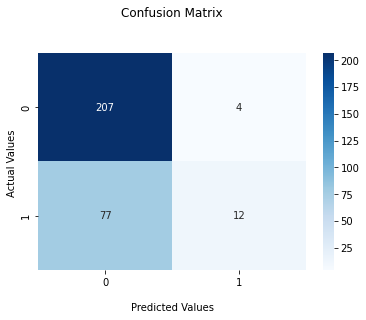

RandomForestClassifier(max_depth=5, random_state=0)

In [442]:
# Declare a function to wrap training of a classifier and printing of performance data
def run_rf_classification_models(X_train: pd.DataFrame, X_test: pd.DataFrame, 
                            y_train: pd.DataFrame, y_test: pd.DataFrame) -> object:
    
    # Scale and transform the data for training
    sclr = StandardScaler()
    sclr.fit(X_train) # scale to 0 mean and std dev 1 on training data

    X_train = sclr.fit_transform(X_train) # scale both sets:
    X_test = sclr.fit_transform(X_test)

    # classifier train
    rf = RandomForestClassifier(max_depth=5,random_state=0)
    rf.fit(X_train,y_train)
    y_train_hat =rf.predict(X_train)
    y_test_hat = rf.predict(X_test)

    # Print score
    print(type(rf))        
    print(f"Accuracy train: {rf.score(X_train,y_train):.4f}, test: ",
      f"{rf.score(X_test,y_test):.4f}")
    print(f"Precision train: {precision_score(y_train, y_train_hat, average=None)[0]:.4f}, test: ",
      f"{precision_score(y_test,y_test_hat, average=None)[0]:.4f}")
    print(f"Recall train: {recall_score(y_train, y_train_hat, average=None)[0]:.4f}, test: ",
      f"{recall_score(y_test,y_test_hat, average=None)[0]:.4f}")
    print(f"F1 train: {f1_score(y_train, y_train_hat, average=None)[1]:.4f}, test: ",
      f"{f1_score(y_test,y_test_hat, average=None)[1]:.4f}")
    #print(f1_score(y_test, y_test_hat, average=None))


    #Print confusion matrix...
    cf_matrix = confusion_matrix(y_test, y_test_hat, labels=[0, 1]) 
    cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

    ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Confusion Matrix\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    plt.show()

    return rf

#run RF classifier function
run_rf_classification_models(X_train, X_test, y_train, y_test)

## Test the performance of different up, and down sampling approaches

### 1) Upsampling using resampling

First we test up-sampling using sklearn's resample, and examine how well it does using the RandomForest classifier. Resampling can up-sample by simply randomly selecting and copying existing observations of the minority class. We can balance the classes in this way.

In [443]:
from sklearn.utils import resample

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Create up-sampled data set for minority class
# note that n_samples= the number of samples the imbalance represents.
X_upsampled, y_upsampled = resample(X_train[y_train == 1],
                                        y_train[y_train == 1],
                                        replace=True,
                                        n_samples=(X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0]),
                                        random_state=None)

#Combine train with upsampled
X_upsampled = X_train.append(X_upsampled)
y_upsampled = y_train.append(y_upsampled)

Let us check everything is in balance now

Imbalanced dataset....
0    498
1    498
Name: class, dtype: int64


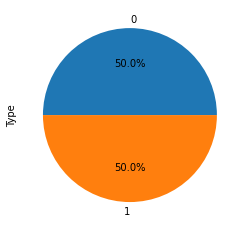

In [444]:
#get pie of the current imbalance
temp = pd.concat([X_upsampled, y_upsampled], axis=1)
pie_of_imbalance(temp)

Dataset is perfectly in balance...

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8223, test:  0.7467
Precision train: 0.8482, test:  0.8462
Recall train: 0.7851, test:  0.7624
F1 train: 0.8287, test:  0.6481


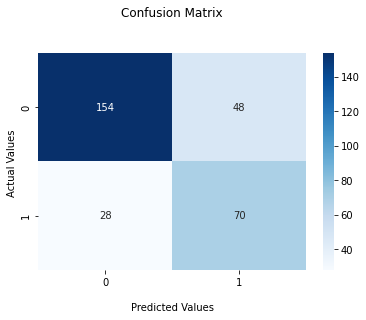

In [445]:
#Run our function....
model = run_rf_classification_models(X_upsampled, X_test, y_upsampled, y_test)

The F1 score on the test data has increased markedly.

### 2) Up-sampling using a synthetic over sampling approach called SMOTE

Add the libraries we will need... and generate the synthetic data to balance our classes using SMOTE.

In [446]:
from imblearn.over_sampling import SMOTE

#How many samples do we need to balance?
idx = np.random.choice(X_train.shape[0], size=X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0], replace=False)

# Generate SMOTE samples and use this to train
upsampler_smote = SMOTE()
X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

Before we use the up-sampled dataset to train our classifier, let us first examine the distribution of the synthetic datapoints that SMOTE creates

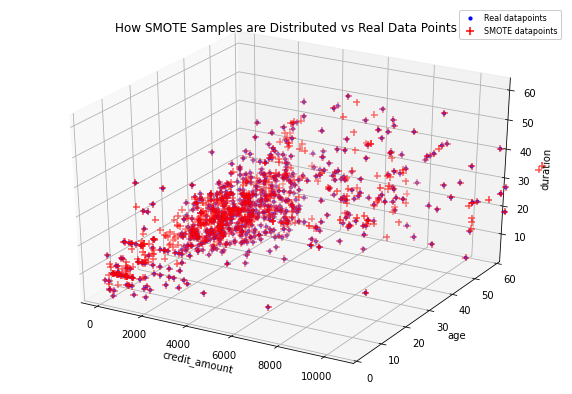

In [447]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_train['credit_amount'],X_train['age'], X_train['duration'], marker="o", s=10, c='blue', label='Real datapoints')
ax.scatter(X_upsampled_smote['credit_amount'],X_upsampled_smote['age'], X_upsampled_smote['duration'], marker="+", s=50, c='red', label='SMOTE datapoints')

# set axes range
plt.xlim(-500, 11000)
plt.ylim(0, 60)

ax.set_xlabel('credit_amount')
ax.set_ylabel('age')
ax.set_zlabel('duration')

plt.title('How SMOTE Samples are Distributed vs Real Data Points')
plt.legend(loc=1,framealpha=1, fontsize=8)
plt.show()

The synthetic datapoints look realistic at a glance.

Imbalanced dataset....
0    498
1    498
Name: class, dtype: int64


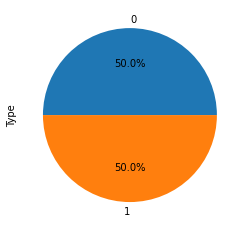

In [448]:
#get pie of the current imbalance
temp = pd.concat([X_upsampled_smote, y_upsampled_smote], axis=1)
pie_of_imbalance(temp)

After up-sampling using SMOTE's synthetic data, the dataset is perfectly in balance...

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8474, test:  0.7500
Precision train: 0.8619, test:  0.8098
Recall train: 0.8273, test:  0.8218
F1 train: 0.8504, test:  0.6114


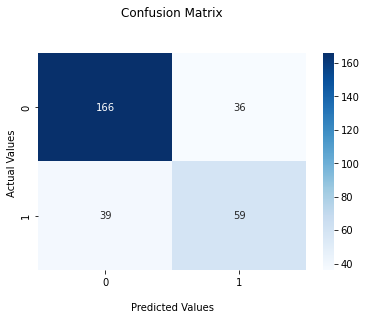

In [449]:
#Run our function....
model = run_rf_classification_models(X_upsampled_smote, X_test, y_upsampled_smote, y_test)

### 3. Down-sampling

Now we can test down-sampling, which is simply removing samples from the majority class. 

In [450]:
from imblearn.under_sampling import RandomUnderSampler 

#Split first to avoid data-snooping
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# Randomly downsample rows in the majority class
rus = RandomUnderSampler(random_state=42)
X_downsampled, y_downsampled = rus.fit_resample(X_train, y_train)

Imbalanced dataset....
0    212
1    212
Name: class, dtype: int64


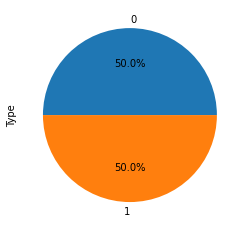

In [451]:
#get pie of the current imbalance
temp = pd.concat([X_downsampled, y_downsampled], axis=1)
pie_of_imbalance(temp)

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8467, test:  0.6800
Precision train: 0.8889, test:  0.8766
Recall train: 0.7925, test:  0.6368
F1 train: 0.8546, test:  0.5897


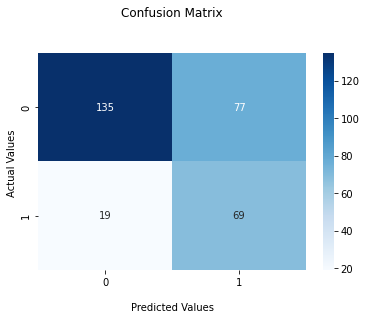

In [452]:
#Run our function....
model = run_rf_classification_models(X_downsampled, X_test, y_downsampled, y_test)

As we can see, all up and down sampling approaches have outperformed the F1 Score on the imbalanced data. The most impressive performance in this case is from up-sampling using SMOTE synthetic data.

## Finally we check for Protected Characteristics ad their Proxies...

We noted at the outset that there was a bias between the protected characterisctis of gender, with male and female credits being different, and we removed this protected characteristic from the dataset to avoid this illegal bias in loan approval outcomes.

Protected characteristics can be picked up (proxied) in other dataitems in more subtle ways though. For instance given that single parent households tend to disproportionately be led by a female adult, this may make 'num_dependents' a proxy for gender.

It is important that we control for any possible protected biases, and one way of achieving this is to retrain our model using a mitigator, which trains by constraining the model weights to produce a balanced outcome between protected classes; male and female credits in this case.

Plot the accuracy of our model for all rows in the data set, plotting accuracy for our protected classes: by male and female credits.

Separate the data into train and test

In [470]:
# Define X and y variables from scratch
cols  = list(df.columns)
cols.remove('class')

# Contains only numerics
X = df[cols]
y = df['class']

# Add binary variable where male=1, female=0
X['gender'] = np.where(df_raw['gender'] == 'female', 1, 0)

#Test and train set    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

Train our classifier using the SMOTE upsampling

In [471]:
#How many samples do we need to balance?
idx = np.random.choice(X_train.shape[0], size=X_train[y_train == 0].shape[0]-X_train[y_train == 1].shape[0], replace=False)

# Generate SMOTE samples and use this to train
upsampler_smote = SMOTE()
X_upsampled_smote, y_upsampled_smote = upsampler_smote.fit_resample(X_train, y_train)

Train the classifier

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy train: 0.8557, test:  0.7033
Precision train: 0.8808, test:  0.8580
Recall train: 0.8227, test:  0.7023
F1 train: 0.8603, test:  0.5742


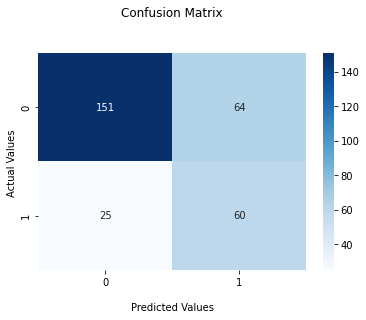

In [472]:
#Remove the gender column
X_upsampled_smote_exgender = X_upsampled_smote.drop('gender', axis=1)
X_test_exgender = X_test.drop('gender', axis=1)

#Run our function....
model = run_rf_classification_models(X_upsampled_smote_exgender, X_test_exgender, y_upsampled_smote, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36495525d0>,
      dtype=object)

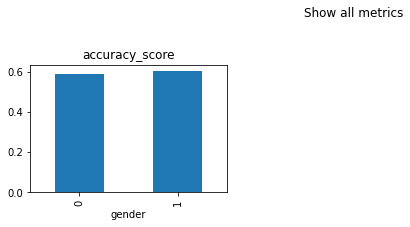

In [473]:
from fairlearn.metrics import MetricFrame
from sklearn.metrics import accuracy_score

# Run classifier, in sample
y_pred = model.predict(X_test_exgender)

# Analyze metrics using MetricFrame
metric_frame = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred, sensitive_features=X_test['gender'])
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

The balance almost equal, this indicates that our model is tending to show now bias based non gender, which indicates that removing the protected dataitem in thefirst place has had a balancing effect on the outcomes. 

However, we can still explicuitly remove correlated features, and constrain model training to remove bias.

### Removing features correlated with protected characteristics

In [474]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.metrics import MetricFrame

In [478]:
# List all the columns that are sensitive, supply in a list...
cr = CorrelationRemover(sensitive_feature_ids=['gender'])
cr.fit(X_upsampled_smote)
X_upsampled_smote_cr = cr.transform(X_upsampled_smote)

In [479]:
# We set the balance in the population so we do not under or over-represent males or females...
constraint = DemographicParity(ratio_bound=0.5)

mitigator = ExponentiatedGradient(model, constraint)
mitigator.fit(X_upsampled_smote_cr, y_train, sensitive_features=['gender'])
y_pred_mitigated = mitigator.predict(X_test_exgender)

sr_mitigated = MetricFrame(metrics=accuracy_score, y_true=y_test, y_pred=y_pred_mitigated, sensitive_features=X_upsampled_smote['gender'])
print(sr_mitigated.overall)
print(sr_mitigated.by_group)

ValueError: ignored

Let us inspect the results between the "fair" model outcomes and the potentially biased....

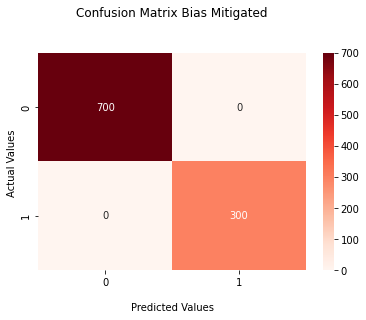

F1 full dataset: 1.0000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3647fc4450>,
      dtype=object)

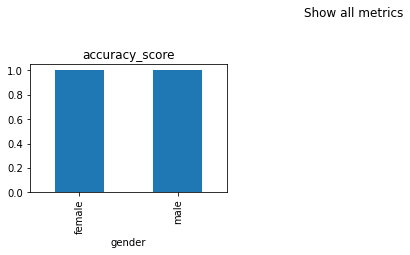

In [463]:

#Print confusion matrix...
cf_matrix = confusion_matrix(y, y_pred_mitigated, labels=[0, 1]) 
cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Reds', fmt='g')
ax.set_title('Confusion Matrix Bias Mitigated\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

print(f"F1 full dataset: {f1_score(y, y_pred_mitigated, average=None)[1]:.4f}")
  
# Analyze metrics using MetricFrame
metric_frame = MetricFrame(metrics=accuracy_score, y_true=y, y_pred=y_pred_mitigated, sensitive_features=df_raw['gender'])
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

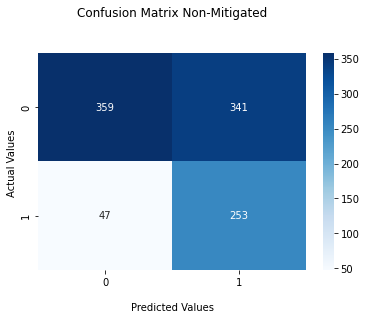

F1 full dataset: 0.5660


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f36486e52d0>,
      dtype=object)

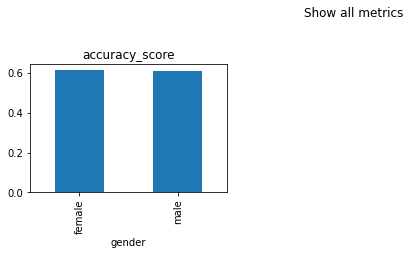

In [464]:
#Print confusion matrix... for the unmitigated classifer...
cf_matrix = confusion_matrix(y, y_pred, labels=[0, 1]) 
cf_matrix_norm = cf_matrix.astype('float') # / cf_matrix.sum(axis=1)[:, np.newaxis]

ax = sns.heatmap(cf_matrix_norm, annot=True, cmap='Blues', fmt='g')
ax.set_title('Confusion Matrix Non-Mitigated\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
plt.show()

print(f"F1 full dataset: {f1_score(y, y_pred, average=None)[1]:.4f}")


# Analyze metrics using MetricFrame
metric_frame = MetricFrame(metrics=accuracy_score, y_true=y, y_pred=y_pred, sensitive_features=df_raw['gender'])
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)